In [800]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib
import mne


# Import MNE processing
from mne_nirs.statistics import statsmodels_to_results, run_glm

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import matplotlib as mpl
from mne.stats import fdr_correction, permutation_t_test


# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools
import glm_analysis
import visualizations
import cross_conditional_comparison

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)
importlib.reload(glm_analysis)
importlib.reload(visualizations)

<module 'visualizations' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py'>

In [801]:
# ------------------------------------------------------------------
# Recurring values that we will allow for users to change in the GUI
# ------------------------------------------------------------------

# Length of the measured interval
interval_length = 50

# Time from trigger point being evaluated
tmin = -1
tmax = 50

# Does the study have variable task lengths or does the study follow a block design?
variable_epoch_time = False



In [802]:
# FV Study Parameters
# ignore = [".DS_Store", ".git", "sub-14", "sub-18", ".gitignore"]
# ignore = [".DS_Store", ".git", "sub-14", "sub-15", "sub-16", "sub-17", "sub-18", "sub-19", ".gitignore"]
# columns_for_group_analysis = ['Neutral', 'Concern']
# columns_for_glm_contrast = ['Neutral', 'Concern']
# path = '../../FV_Prelim_Data/'
# trigger_id = {'1': 'Start', '2': 'Neutral', '3': 'Concern'}
# columns_for_fdr = ['Neutral', 'Concern']
# sc_present = False

In [803]:
# Chatbot Study
# ignore = [".DS_Store", ".git", ".gitignore"]
# columns_for_group_analysis = ['oneBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'threeBack']
# trigger_id = None
# path = '../../Chatbot_results_final/data/'
# custom_triggers = True
# custom_trigger_df = '../../Chatbot_results_final/custom_events.csv'
# columns_for_fdr = ['oneBack', 'threeBack']
# sc_present = False
# event_dcit = {'oneBack': 1, 'threeBack': 3, 'choice_agreeable': 4, 'open_neutral': 5, 'choice_neutral': 6, 'open_agreeable': 7}

In [804]:
# FA Study Parameters
# columns_for_group_analysis = ['Neutral', 'Inflam', 'Control']
# columns_for_glm_contrast = ['Neutral', 'Inflam', 'Control']
# columns_for_fdr = ['Control', 'Inflam']
# path = "../../LabResearch/IndependentStudy/Data/FA"
# ignore = [".DS_Store", "sub-03", ".git", ".gitignore"]
# trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflam', '1':'Practice'}

In [805]:
# Oculus Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/oculus_montage_bids/'
# ignore = [".DS_Store", "sub-1", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}
# custom_trigger_df = False

In [806]:
# N-Back Control Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/n-back-bids/'
# ignore = [".DS_Store", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

In [807]:
# Live Drive
# ignore = [".DS_Store", ".git", "sub-01", ".gitignore"]
# columns_for_group_analysis = ['Driving']
# columns_for_glm_contrast = ['Driving']
# path = '../../LiveDrive'
# trigger_id = {'2': 'Driving'}
# columns_for_fdr = ['Driving']

In [808]:
# VR Driving
# ignore = [".DS_Store", ".git", ".gitignore"]
# columns_for_group_analysis = ['Driving']
# columns_for_glm_contrast = ['Driving']
# path = '../../Drive_VR/'
# trigger_id = {'2': 'Driving'}
# columns_for_fdr = ['Driving']
# sc_present = True

In [809]:
# Live Drive w/ Pause
# ignore = [".DS_Store", ".git", ".gitignore"]
# columns_for_group_analysis = ['Driving']
# columns_for_glm_contrast = ['Driving']
# path = '../../Driving_with_pause/'
# trigger_id = {'2': 'Driving'}
# columns_for_fdr = ['Driving']
# sc_present = True

In [810]:
# Attention Shifting
columns_for_group_analysis = ['Both', 'Sound', 'Visual']
columns_for_glm_contrast = ['Visual', 'Sound', 'Both']
columns_for_fdr = ['Visual', 'Both']
path = '../../AttentionShiftingData/'
ignore = [".DS_Store", ".git", ".gitignore"]
trigger_id = {'1': 'Visual', '2': 'Sound', '3': 'Both'}
custom_trigger_df = False
sc_present = True

In [811]:

def run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, custom_trigger_df, tmin=None, tmax=None, trigger_id=None):
    # Establish the groups, subject names, and snirf file paths for all subjects
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}
    print("Path", path)
    for group in groups:
        paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()

        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(custom_trigger_df, paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time, tmin=tmin, tmax=tmax)
        
        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, sc_present, tmin, tmax)
        print("GLM Data Processed ---> Calcuating GLM Dataframe")
        
        # Converts the glm design matrixes into a dataframe
        df_cha, glm_results, contrasts = glm_analysis.create_glm_df(glm_data, columns_for_fdr)
        
        print('All Data', all_data)
        raw_haemo = all_data[0]['raw_haemo']
        
        print("GLM Dataframe Generated. Finding all significant channels")
        # Find the groups significant channels
        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[group] = {"channels_df": df_cha, "contrasts_dict": contrasts, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results, glm_data

In [812]:
def run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, custom_trigger_df, tmin=None, tmax=None, trigger_id=None):
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}

    paths = df[df.any(1)]['snirf_path'].to_numpy()
    
    for id, path in enumerate(paths):
        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(custom_trigger_df, paths=[path], trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, sc_present, tmin, tmax)

        raw_haemo = all_data[0]['raw_haemo']

        # Converts the glm design matrixes into a dataframe
        df_cha, glm_results, contrasts = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[f'sub-{id+1}'] = {"channels_df": df_cha, "contrasts_dict": contrasts, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results, glm_data

In [813]:
importlib.reload(analysis_tools)
importlib.reload(glm_analysis)
print(sc_present)
group_data, all_epochs, all_evokeds, glm_results, glm_data = run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, custom_trigger_df, tmin=tmin, tmax=tmax, trigger_id=trigger_id)

# print(glm_results)


True
Path ../../AttentionShiftingData/
False ['../../AttentionShiftingData//All/sub-6/nirs/2023-05-23_008.snirf'
 '../../AttentionShiftingData//All/sub-1/nirs/2023-05-22_001.snirf'
 '../../AttentionShiftingData//All/sub-2/nirs/2023-05-22_002.snirf'
 '../../AttentionShiftingData//All/sub-5/nirs/2023-05-23_007.snirf'
 '../../AttentionShiftingData//All/sub-4/nirs/2023-05-23_001.snirf'
 '../../AttentionShiftingData//All/sub-3/nirs/2023-05-22_003.snirf'] {'1': 'Visual', '2': 'Sound', '3': 'Both'} False -1 50
['../../AttentionShiftingData//All/sub-6/nirs/2023-05-23_008.snirf', '../../AttentionShiftingData//All/sub-1/nirs/2023-05-22_001.snirf', '../../AttentionShiftingData//All/sub-2/nirs/2023-05-22_002.snirf', '../../AttentionShiftingData//All/sub-5/nirs/2023-05-23_007.snirf', '../../AttentionShiftingData//All/sub-4/nirs/2023-05-23_001.snirf', '../../AttentionShiftingData//All/sub-3/nirs/2023-05-22_003.snirf']
bids_path ../../AttentionShiftingData//All/sub-6/nirs/2023-05-23_008.snirf
bids_pa

/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:138: UserWarning: Removing first event for FAST Study. Change for other studies
  events.pop(0)


Does this fire? <RawSNIRF | 2023-05-22_001.snirf, 52 x 17833 (1752.9 s), ~173 kB, data not loaded>
Reading 0 ... 17832  =      0.000 ...  1752.886 secs...
Past raw generation
No custom triggers path firing
[[ 143    0    3]
 [ 207    0    3]
 [ 276    0    3]
 [ 340    0    3]
 [ 574    0    2]
 [ 638    0    2]
 [ 703    0    2]
 [ 773    0    2]
 [ 870    0    2]
 [1060    0    1]
 [1124    0    1]
 [1188    0    1]
 [1253    0    1]]
Epochs [<Epochs |  13 events (all good), -1.25 - 50 sec, baseline -1.25 – 0 sec, ~313 kB, data loaded,
 'Both': 4
 'Sound': 5
 'Visual': 4>]
Epochs {'epoch': <Epochs |  13 events (all good), -1.25 - 50 sec, baseline -1.25 – 0 sec, ~313 kB, data loaded,
 'Both': 4
 'Sound': 5
 'Visual': 4>, 'condition': 'Both', 'raw_haemo': <RawSNIRF | 2023-05-22_001.snirf, 36 x 1402 (1751.2 s), ~553 kB, data loaded>, 'raw_intensity': <RawSNIRF | 2023-05-22_001.snirf, 36 x 17833 (1752.9 s), ~5.1 MB, data loaded>, 'f_path': '../../AttentionShiftingData//All/sub-1/nirs/202

/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:138: UserWarning: Removing first event for FAST Study. Change for other studies
  events.pop(0)


Does this fire? <RawSNIRF | 2023-05-22_002.snirf, 52 x 16407 (1612.7 s), ~173 kB, data not loaded>
Reading 0 ... 16406  =      0.000 ...  1612.710 secs...
Past raw generation
No custom triggers path firing
[[  82    0    3]
 [ 150    0    3]
 [ 229    0    3]
 [ 293    0    3]
 [ 584    0    1]
 [ 648    0    1]
 [ 712    0    1]
 [ 795    0    1]
 [1037    0    2]
 [1101    0    2]
 [1165    0    2]
 [1232    0    2]]
Epochs [<Epochs |  12 events (all good), -1.25 - 50 sec, baseline -1.25 – 0 sec, ~301 kB, data loaded,
 'Both': 4
 'Sound': 4
 'Visual': 4>]
Epochs {'epoch': <Epochs |  12 events (all good), -1.25 - 50 sec, baseline -1.25 – 0 sec, ~301 kB, data loaded,
 'Both': 4
 'Sound': 4
 'Visual': 4>, 'condition': 'Both', 'raw_haemo': <RawSNIRF | 2023-05-22_002.snirf, 36 x 1290 (1611.2 s), ~522 kB, data loaded>, 'raw_intensity': <RawSNIRF | 2023-05-22_002.snirf, 36 x 16407 (1612.7 s), ~4.7 MB, data loaded>, 'f_path': '../../AttentionShiftingData//All/sub-2/nirs/2023-05-22_002.snirf'

/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:138: UserWarning: Removing first event for FAST Study. Change for other studies
  events.pop(0)


Does this fire? <RawSNIRF | 2023-05-23_007.snirf, 52 x 12529 (1231.5 s), ~173 kB, data not loaded>
Reading 0 ... 12528  =      0.000 ...  1231.502 secs...
Past raw generation
No custom triggers path firing
[[ 86   0   1]
 [153   0   1]
 [217   0   1]
 [351   0   3]
 [416   0   3]
 [490   0   3]
 [581   0   3]
 [724   0   2]
 [788   0   2]
 [858   0   2]
 [924   0   2]]
Epochs [<Epochs |  8 events (all good), -1.25 - 50 sec, baseline -1.25 – 0 sec, ~254 kB, data loaded,
 'Both': 1
 'Sound': 3
 'Visual': 4>]
Epochs {'epoch': <Epochs |  8 events (all good), -1.25 - 50 sec, baseline -1.25 – 0 sec, ~254 kB, data loaded,
 'Both': 1
 'Sound': 3
 'Visual': 4>, 'condition': 'Both', 'raw_haemo': <RawSNIRF | 2023-05-23_007.snirf, 36 x 985 (1230.0 s), ~436 kB, data loaded>, 'raw_intensity': <RawSNIRF | 2023-05-23_007.snirf, 36 x 12529 (1231.5 s), ~3.6 MB, data loaded>, 'f_path': '../../AttentionShiftingData//All/sub-5/nirs/2023-05-23_007.snirf', 'ID': 5, 'aux_df':          accelerometer_1_x  accel

/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:138: UserWarning: Removing first event for FAST Study. Change for other studies
  events.pop(0)


Does this fire? <RawSNIRF | 2023-05-23_001.snirf, 52 x 15725 (1545.7 s), ~173 kB, data not loaded>
Reading 0 ... 15724  =      0.000 ...  1545.669 secs...
Past raw generation
No custom triggers path firing
[[  92    0    2]
 [ 163    0    2]
 [ 232    0    2]
 [ 390    0    1]
 [ 454    0    1]
 [ 523    0    1]
 [ 646    0    1]
 [ 819    0    3]
 [ 883    0    3]
 [ 948    0    3]
 [1094    0    3]
 [1189    0    3]]
Epochs [<Epochs |  12 events (all good), -1.25 - 50 sec, baseline -1.25 – 0 sec, ~281 kB, data loaded,
 'Both': 4
 'Sound': 3
 'Visual': 5>]
Epochs {'epoch': <Epochs |  12 events (all good), -1.25 - 50 sec, baseline -1.25 – 0 sec, ~281 kB, data loaded,
 'Both': 4
 'Sound': 3
 'Visual': 5>, 'condition': 'Both', 'raw_haemo': <RawSNIRF | 2023-05-23_001.snirf, 32 x 1237 (1545.0 s), ~465 kB, data loaded>, 'raw_intensity': <RawSNIRF | 2023-05-23_001.snirf, 36 x 15725 (1545.7 s), ~4.5 MB, data loaded>, 'f_path': '../../AttentionShiftingData//All/sub-4/nirs/2023-05-23_001.snirf'

/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:138: UserWarning: Removing first event for FAST Study. Change for other studies
  events.pop(0)


Does this fire? <RawSNIRF | 2023-05-22_003.snirf, 52 x 15683 (1541.5 s), ~173 kB, data not loaded>
Reading 0 ... 15682  =      0.000 ...  1541.541 secs...
Past raw generation
No custom triggers path firing
[[  80    0    2]
 [ 144    0    2]
 [ 221    0    2]
 [ 583    0    3]
 [ 647    0    3]
 [ 711    0    3]
 [ 792    0    3]
 [ 969    0    1]
 [1033    0    1]
 [1097    0    1]
 [1168    0    1]]
Epochs [<Epochs |  9 events (all good), -1.25 - 50 sec, baseline -1.25 – 0 sec, ~250 kB, data loaded,
 'Both': 4
 'Sound': 1
 'Visual': 4>]
Epochs {'epoch': <Epochs |  9 events (all good), -1.25 - 50 sec, baseline -1.25 – 0 sec, ~250 kB, data loaded,
 'Both': 4
 'Sound': 1
 'Visual': 4>, 'condition': 'Both', 'raw_haemo': <RawSNIRF | 2023-05-22_003.snirf, 32 x 1233 (1540.0 s), ~464 kB, data loaded>, 'raw_intensity': <RawSNIRF | 2023-05-22_003.snirf, 36 x 15683 (1541.5 s), ~4.5 MB, data loaded>, 'f_path': '../../AttentionShiftingData//All/sub-3/nirs/2023-05-22_003.snirf', 'ID': 3, 'aux_df':

/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:138: UserWarning: Removing first event for FAST Study. Change for other studies
  events.pop(0)


Epochs {'epoch': <Epochs |  9 events (all good), -1.25 - 50 sec, baseline -1.25 – 0 sec, ~250 kB, data loaded,
 'Both': 4
 'Sound': 1
 'Visual': 4>, 'condition': 'Visual', 'raw_haemo': <RawSNIRF | 2023-05-22_003.snirf, 32 x 1233 (1540.0 s), ~464 kB, data loaded>, 'raw_intensity': <RawSNIRF | 2023-05-22_003.snirf, 36 x 15683 (1541.5 s), ~4.5 MB, data loaded>, 'f_path': '../../AttentionShiftingData//All/sub-3/nirs/2023-05-22_003.snirf', 'ID': 3, 'aux_df':          accelerometer_1_x  accelerometer_1_y  accelerometer_1_z  \
times                                                              
0.00              1.066000          -7.728000          -6.554000   
1.25              0.371039          -3.241012          -9.052155   
2.50              1.278416           5.454533          -8.775062   
3.75              1.623214           3.384931          -9.644137   
5.00             -0.537595           0.306696          -9.971513   
...                    ...                ...                ...  

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipelin

In [814]:
# individual_data, all_epochs, all_evokeds, glm_data = run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, custom_trigger_df, trigger_id)
# individual_data

# Visualizations

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[vals] = model_data[vals].astype(float)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:79: SettingWithCopyWarning: 
A value

Reducing GLM results to match MNE data
Reducing GLM results to match MNE data
Reducing GLM results to match MNE data


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[vals] = model_data[vals].astype(float)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:79: SettingWithCopyWarning: 
A value

Reducing GLM results to match MNE data
Reducing GLM results to match MNE data
Reducing GLM results to match MNE data


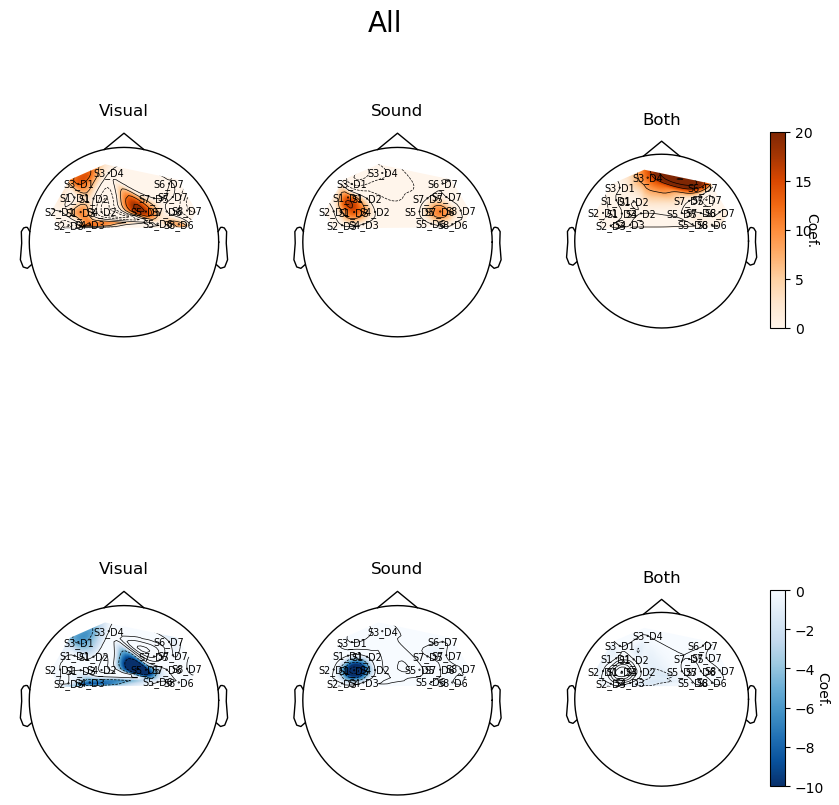

In [815]:
# Group Visualization
importlib.reload(visualizations)
groups = list(group_data.keys())
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_dict, significant_channels, all_data = group_data[group].values()
    raw_haemo = all_data[0]['raw_haemo']
    visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo, group)

Contrasts Dict {'contrast_1': variable ContrastType        effect   p_value      stat   z_score Source  \
0                   t -6.070598e-06  0.979387 -2.043823 -2.041245      1   
1                   t -2.531248e-06  0.760509 -0.708199 -0.707939      1   
2                   t  3.280182e-06  0.203675  0.828908  0.828567      1   
3                   t -7.705454e-07  0.594256 -0.238569 -0.238507      2   
4                   t -6.343075e-07  0.578220 -0.197393 -0.197343      2   
..                ...           ...       ...       ...       ...    ...   
613                 t  3.123536e-06  0.377326  0.312583  0.312512      7   
614                 t -1.128818e-06  0.741996 -0.649705 -0.649512      7   
615                 t -2.440101e-06  0.934766 -1.513298 -1.512259      7   
616                 t -5.212732e-07  0.593655 -0.237009 -0.236957      8   
617                 t  8.662274e-07  0.356135  0.368896  0.368808      8   

variable Detector Chroma  Significant    ch_name  ID  
0 

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/cross_conditional_comparison.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


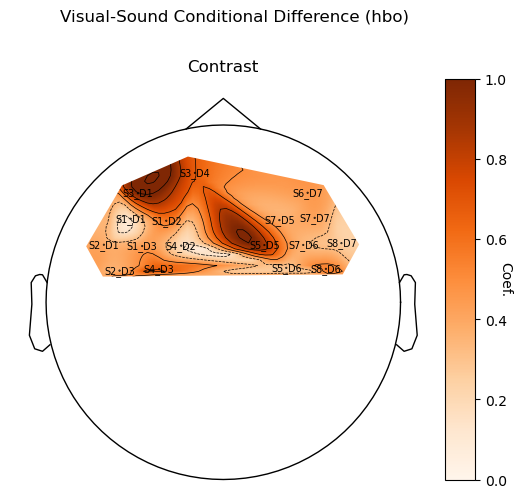

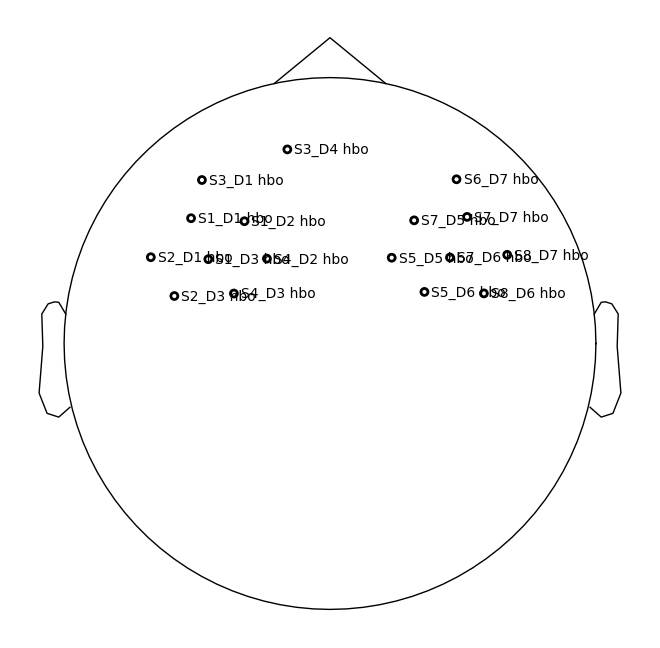

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/cross_conditional_comparison.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


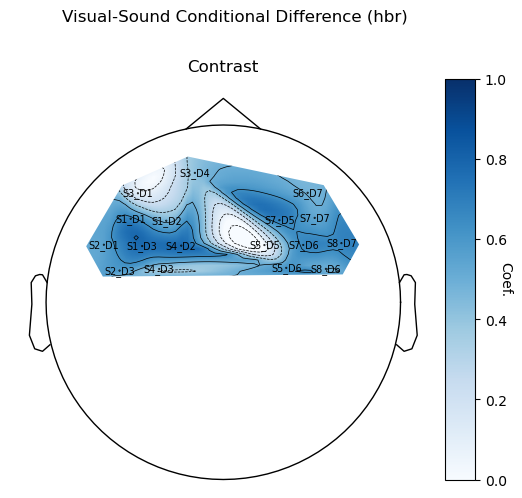

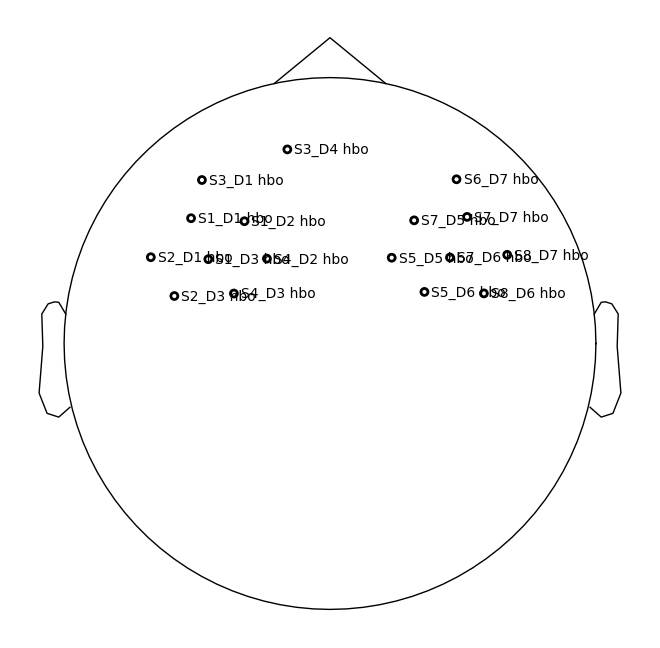

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/cross_conditional_comparison.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


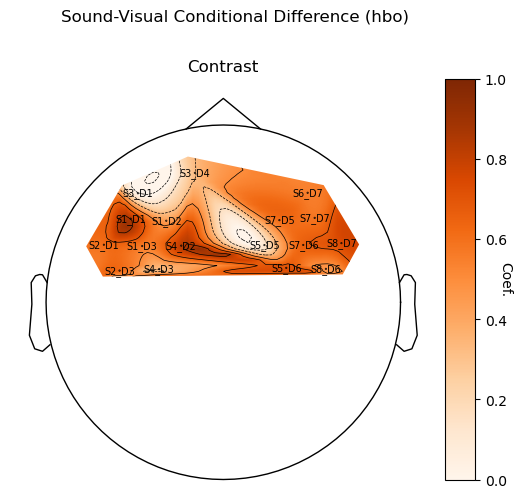

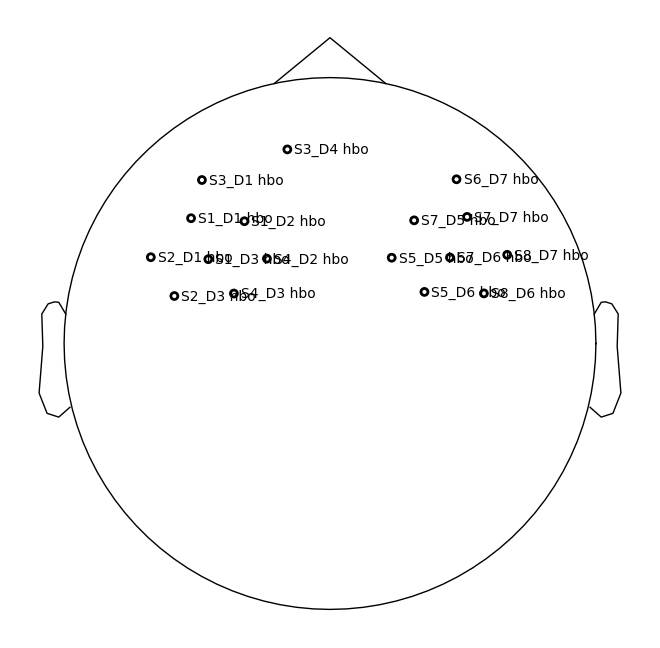

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/cross_conditional_comparison.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


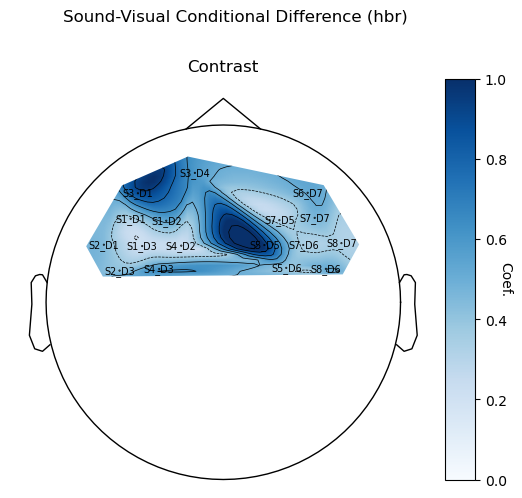

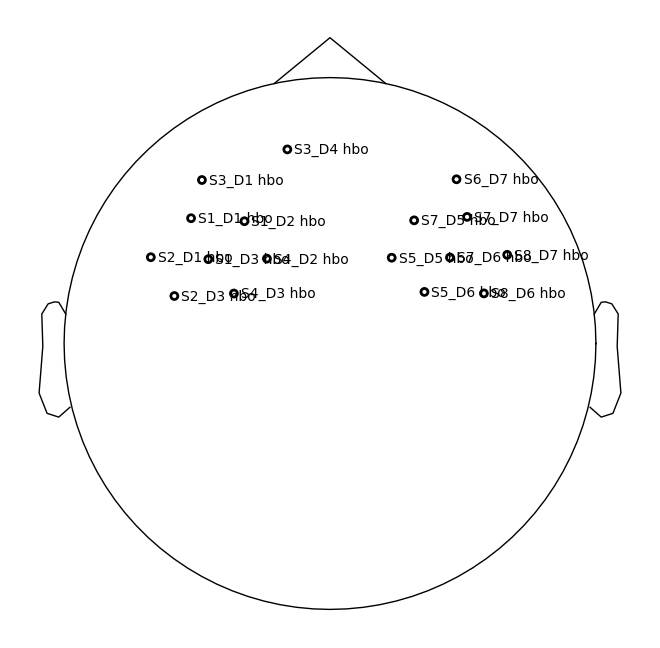

In [816]:
# Compare the results between two conditions
importlib.reload(visualizations)
importlib.reload(analysis_tools)
importlib.reload(cross_conditional_comparison)
epochs = []
raw_data = []


groups = list(group_data.keys())
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_dict, significant_channels, all_data = group_data[group].values()
    raw_haemo = all_data[0]['raw_haemo']

cross_conditional_comparison.two_sample_permutation_test(group_data, raw_haemo, columns_for_fdr, contrasts_dict)



In [817]:
# Generate FDR Corrected Results
importlib.reload(visualizations)
importlib.reload(analysis_tools)
ignored_vals = ['drift', 'Start', 'constant']

groups = list(group_data.keys())
results = {}
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()
    
    raw_haemo = all_data[0]['raw_haemo']

    alpha = 0.05
    p_vals = channels_df['p_value']
    reject_fdr, pval_fdr = fdr_correction(p_vals, alpha=alpha, method='indep')
    channels_df['fdr_status'] = reject_fdr
    
    # Find all the channels that survive FDR and are not drift values
    channels_df_fdr = channels_df.loc[(channels_df['fdr_status'] == True) & (~channels_df['Condition'].isin(ignored_vals))]
    channels_df_fdr = channels_df_fdr.drop_duplicates()
    print(channels_df_fdr)
    channels_df_fdr.to_csv('FV_results_FDR.csv')
    
    # channels_df_fdr.to_csv('channels_df_fdr.csv')
    # visualizations.group_topological_visualisation(channels_df_fdr, columns_for_glm_contrast, raw_haemo, group)

variable Condition    df           mse       p_value        se          t  \
1         ShortHbO  32.0  2.379812e-11  1.144374e-04  0.391356   4.394010   
65        ShortHbO  32.0  4.885546e-11  3.148491e-08  0.560697   7.242742   
66        ShortHbR  32.0  4.885546e-11  2.855134e-05  1.326055   4.875203   
97        ShortHbO  32.0  1.879664e-11  5.267585e-04  0.343436   3.854079   
161       ShortHbO  32.0  3.432974e-11  8.355638e-17  0.469057  15.974343   
...            ...   ...           ...           ...       ...        ...   
19538     ShortHbR  36.0  7.020770e-12  3.248135e-13  0.074056 -11.135997   
19573     ShortHbO  36.0  1.306224e-11  9.064712e-13  0.067698 -10.733552   
19574     ShortHbR  36.0  1.306224e-11  3.169065e-08  0.101013  -7.011677   
19609     ShortHbO  36.0  1.090166e-11  1.871400e-13  0.061862 -11.355650   
19610     ShortHbR  36.0  1.090166e-11  3.133722e-08  0.092482  -7.015392   

variable     theta Source Detector Chroma  Significant    ch_name  ID  \
1 

In [818]:
# Permutation T-test

all_data = group_data['all_groups']['all_data']
epochs = []

for d in all_data:
    # epochs.append(data['epoch'])
    raw = d['raw_haemo']
    picks = mne.pick_types(raw.info, fnirs=True, meg=False, eeg=False, stim=False, eog=True,
                       exclude='bads')

    data = d['epoch'].get_data()
    times = d['epoch'].times

    temporal_mask = np.logical_and(0.04 <= times, times <= 0.06)
    data = np.mean(data[:, :, temporal_mask], axis=2)

    n_permutations = 50000
    T0, p_values, H0 = permutation_t_test(data, n_permutations, n_jobs=None)
    print(T0, H0)
    significant_sensors = picks[p_values <= 0.05]
    significant_sensors_names = [raw.ch_names[k] for k in significant_sensors]

    print(significant_sensors_names)


KeyError: 'all_groups'

In [ ]:
# # Group Cortical Projections
# importlib.reload(visualizations)
# groups = list(group_data.keys())
# for group in groups:
#     # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
#     channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

#     raw_haemo = all_data[0]['raw_haemo']
#     visualizations.group_cortical_surface_projection(channels_df, columns_for_glm_contrast, raw_haemo, path)

defaultdict(<class 'list'>, {'Both': [<Evoked | 'Both' (average, N=4), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Both' (average, N=4), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Both' (average, N=4), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Both' (average, N=2), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Both' (average, N=4), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Both' (average, N=4), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>], 'Sound': [<Evoked | 'Sound' (average, N=4), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Sound' (average, N=5), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Sound' (average, N=4), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Sound' (average, N=3), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Sound' (average, N=4), -1.25 – 50 se

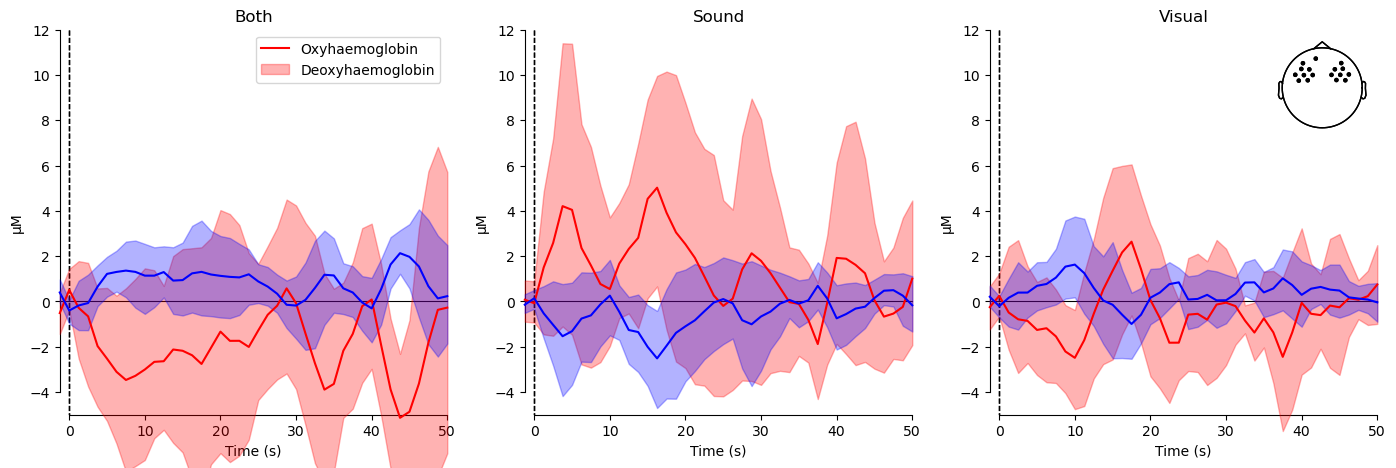

In [ ]:
importlib.reload(visualizations)
visualizations.plot_waveform_analysis(all_evokeds, variable_epoch_time)

In [ ]:
# Individual Visualization
# importlib.reload(visualizations)
# if individual_data:
#     channels_df, contrasts_df, significant_channels, all_data = individual_data['sub-1'].values()

#     raw_haemo = all_data[0]['raw_haemo']

#     visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

# Export Results

In [ ]:
# Download the Results
keys = list(group_data.keys())
complete_results = pd.DataFrame()
for key in keys:
    sig_cha = group_data[key]['significant_channels']
    print(sig_cha)
    sig_cha['group'] = key
    complete_results = pd.concat([complete_results, sig_cha])
    complete_results['Coef.'] = complete_results['Coef.'] * 1e7
complete_results.to_csv('FV_results.csv')

                            Coef. Std.Err.         z         P>|z|    [0.025  \
ch_name   Condition                                                            
S2_D1 hbo Concern   -1.060151e-06      0.0 -2.963398  3.042631e-03 -0.000002   
          Neutral   -9.047090e-07      0.0 -2.528898  1.144213e-02 -0.000002   
S2_D3 hbo Neutral   -1.152084e-06      0.0 -3.220376  1.280226e-03 -0.000002   
S3_D4 hbo Neutral    8.481680e-07      0.0  2.370851  1.774718e-02       0.0   
S4_D4 hbo Neutral    8.889491e-07      0.0  2.484845  1.296079e-02       0.0   
S4_D5 hbo Neutral    7.473049e-07      0.0  2.088912  3.671560e-02       0.0   
S5_D4 hbo Concern    1.200302e-06      0.0  3.355159  7.931937e-04       0.0   
          Neutral    1.214254e-06      0.0  3.394157  6.884016e-04  0.000001   
S5_D6 hbo Concern    1.016629e-06      0.0  2.841744  4.486745e-03       0.0   
S6_D4 hbo Concern    8.835907e-07      0.0  2.469867  1.351633e-02       0.0   
          Neutral    9.736732e-07      0